# 基于神经网络的语义模型（word2vec）

在此，我将示范如何利用Tensorflow完成基于skip-gram框架的word2vec算法。同时，也将展示“词向量”（word embedding）在自然语言处理中的作用。这种方法使得分析字符串的自然语义成为可能。为风险建模中的如同：行业信息，地址信息的匹配提供方法。

## 参考文献
以下是一些非常有用的参考文献，我建议各位感兴趣的话可以深入了解。

* 一个非常好的关于word2vec的[概念性综述](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) -- Chris McCormick
* [第一篇关于word2vec的论文](https://arxiv.org/pdf/1301.3781.pdf) -- Mikolov et al.
* [对于word2vec的一些改进](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) -- Mikolov et al.
* [word2vec的一些应用](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) -- Thushan Ganegedara
* [TensorFlow官网上的word2vec教程](https://www.tensorflow.org/tutorials/word2vec)

## Tensorflow
TensorFlow™ 是一个采用数据流图（data flow graphs），用于数值计算的开源软件库。节点（Nodes）在图中表示数学操作，图中的线（edges）则表示在节点间相互联系的多维数据数组，即张量（tensor）。它灵活的架构让你可以在多种平台上展开计算，例如台式计算机中的一个或多个CPU（或GPU），服务器，移动设备等等。TensorFlow 最初由Google大脑小组（隶属于Google机器智能研究机构）的研究员和工程师们开发出来，用于机器学习和深度神经网络方面的研究，但这个系统的通用性使其也可广泛用于其他计算领域。
<img src="assets/timg.jpg" width='300'>

## 词向量/词嵌入（Word embeddings）

当在处理与语言相关的问题时，每一个词都相当于一个分类。因此最终你将面临的问题将是成百上千个分类的分类问题。传统的处理方法是将这些词做独热表示（one-hot encode），但这是非常低效的。试想一下，如果我们的文本库里一共包含50000个词，那么单个词的表示将是一个50000维的向量。其中的一个元素为1，其余的均为0。word2vec算法找到了一种更加有效的表示方法，那就是利用不稀疏的向量表示词汇。这些向量包含了词义信息。例如根据贷款申请单的工作单位进行词向量表示后，得到了如下的相似度表示：
<img src="assets/word_similar.png"  width="250"> 

既然可以将词汇表示为向量，那么一些更有趣的效果也产生了。
如：“男人”对于“女人”作用在“国王”上，得到的结果是“王后”。作用在“叔叔”上，得到的结果是“阿姨”。
<img src="assets/word2vec_showup.jpg"  width="500"> 

存在两种不同的算法架构实现word2vec，分别是CBOW (Continuous Bag-Of-Words) 以及 Skip-gram.
<img src="assets/word2vec_architectures.png"  width="500">

在这里我们将使用Skip-gram框架，这是因为skip-gram在效果上表现的更好。我们传入一个词去预测这个词在文章中附近的词汇。以此去描述一个词在空间中所在的位置。


首先，载入需要的计算框架

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

为方便演示（因为英语使用空格分割词汇，中文则需要进一步处理，如利用jieba或snownlp进行分词），在这里我们使用的实例文件是[text8 dataset](http://mattmahoney.net/dc/textdata.html)（一个清理过的英文版维基百科文件） -- by Matt Mahoney），下面的代码将执行下载任务以及解压工作。

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## 预处理(Preprocess)

这一部分将对文本信息做基本的预处理。大部分的处理函数在util模块中。preprocess函数将所有的标点处理为标签，例如“，”会被替换为“ <PERIOD> ”。在这个数据集中虽然不存在任何标点，但是preprocess函数可以应用在其他NLP问题上。同时，preprocess还去除了出现次数小于5次的词汇，去除了一些噪声，提高了向量表示的质量。

In [3]:
words = utils.preprocess(text)
print(words[:100])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


为了让计算机可以识别词汇，我们需要对词汇进行编码，按照出现的词频进行排序，最频繁出现的词如“the”的索引号为0，依次增加。 
word被转换为整数的形式存在列表“int_words”中。

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## 下采样(Subsampling)

如“the”，“of”，“for”这样词频很高的词一般而言对上下文来说没有多大意义。如果可以去掉一些可以让训练速度更快，同时也可以产生更好的表示矩阵。这一过程称之为“下采样”(subsampling)（Mikolov）。对于训练集中的每个词$w_i$，我们按概率遗弃它。概率由下式给出：

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

其中$t$为阈值参数，$f(w_i)$是$w_i$在整个数据集中的词频。

In [6]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if p_drop[word] < random.random()]

## 批处理（Making batches）

我们需要将数据进一步转换为适合网络计算的形式。因为采用了skip-gram架构，对于文章中的每个词，我们希望按窗口大小获取这个词周围的所有词。


[Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf)中提到: 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

即：距离较远的词通常相关度没有距离较近的词大。在采样时我们设定一个窗口大小如：$C = 5$，在区间$< 1; C >$随机确定一个$R$。采样这个词的前后$R$个词作为正确的标签。（这意味着较近的词有较大的采样权重）

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

同时，由于数据量很大，我们采用了Minibatch Stochastic Gradient Decent更新权重，寻求Cost Function的最小值。

这提高了训练速度，也避免了每次更新权重都使用整个数据集，可能导致内存溢出的问题。

batch_size一般取：128,256,512

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## 创建网络

神经网络的示意图如图（Chris McCormick's blog）：
![embedding_network](./assets/skip_gram_net_arch.png)

我们传入的独热表示的词，首先经过了隐藏层的线性单元，随后进入softmax（因为是多分类问题）层，利用softmax层实现预测

我们的目的是要训练隐藏层的权重，这些权重矩阵就是我们所要找的词汇的高效表达方式。权重矩阵一般也被称为“词向量矩阵”或“词向量查询表”。至于softmax层的输出，我们可以不加理会。因为我们的目的是寻找词汇在空间中的向量表示，而不是最终的预测结果。

首先创建Graph，并对inputs 与 labels创建对应的占位符

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## 词向量（Embedding）



词向量矩阵的大小为：$总词数\times隐藏层的神经元数$。因此，假设存在10000个单词，隐藏层的神经元数为300个，那么词向量矩阵的大小为：$10,000 \times 300$。由于我们输入的是一维独热表示的向量，当执行矩阵乘法操作后，相当于选择了词向量矩阵中的一行：

![one-hot matrix multiplication](assets/matrix_mult_w_one_hot.png)

事实上，无需真的执行矩阵乘法操作，只需要去选择词向量矩阵中对应的行就可以了。这就是为什么词向量矩阵又可以被称作词向量查询表的缘故。

也可以这么说，我们使用了“隐藏层的神经元个数”的特征去描述一个特定的词
<img src="assets/word2vec_weight_matrix_lookup_table.png" width=500>


Tensorflow 提供里一个非常便利的函数[`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup)，方便我们查询词向量空间中的行。传入词向量矩阵与一个整数张量，函数返回词向量矩阵中对应的行。

下面我们采用200个特征的词向量矩阵，并且利用`tf.nn.embedding_lookup`去寻找对应的词向量。
词向量矩阵本质上是一个权重矩阵。在神经网络中，权重矩阵的初始化尤为关键，我们使用的是随机均匀分布的矩阵初始化方法。
[tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

当然我相信采用truncated_normal 正态分布的权重初始化效果会更好。

In [10]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## 负采样（Negative sampling）



对于输入到网络中的每一个样本，我们使用了softmax的输出去训练整个网络。这意味着对于每一个输入样本，即使我们只有一个元素为真，我们也要去调整数百万计的权重。以这样的方式训练网络是十分低效的。我们可以只更新所有权重的一个非常小的子集，即更新正确的分类所对应的权重以及一小部分错分类所对应的权重。这种方法称之为负采样["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Tensorflow提供了一个非常便利的函数实现此功能：[`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## 校验（Validation）

我们选取了最常出现和不常出现的各8个词汇，输出与其相似的词。以检验词向量矩阵是否将词义相近的词聚合在一起。

In [15]:
with train_graph.as_default():
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [16]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

In [ ]:
epochs = 50
batch_size = 512
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/50 Iteration: 100 Avg. Training loss: 5.7089 0.0000 sec/batch
Epoch 1/50 Iteration: 200 Avg. Training loss: 5.5819 0.0000 sec/batch
Epoch 1/50 Iteration: 300 Avg. Training loss: 5.5781 0.0000 sec/batch
Epoch 1/50 Iteration: 400 Avg. Training loss: 5.6029 0.0000 sec/batch


保存的模型可以重复的提取:

In [25]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

## 可视化词向量（Visualizing the word vectors）

下面我们将使用T-SNE可视化高维词向量空间。T-SNE可以在保留原始结构的基础上将高维数据投影在二维空间中。

想要进一步了解T-SNE可以查看以下链接：[this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)


In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [47]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

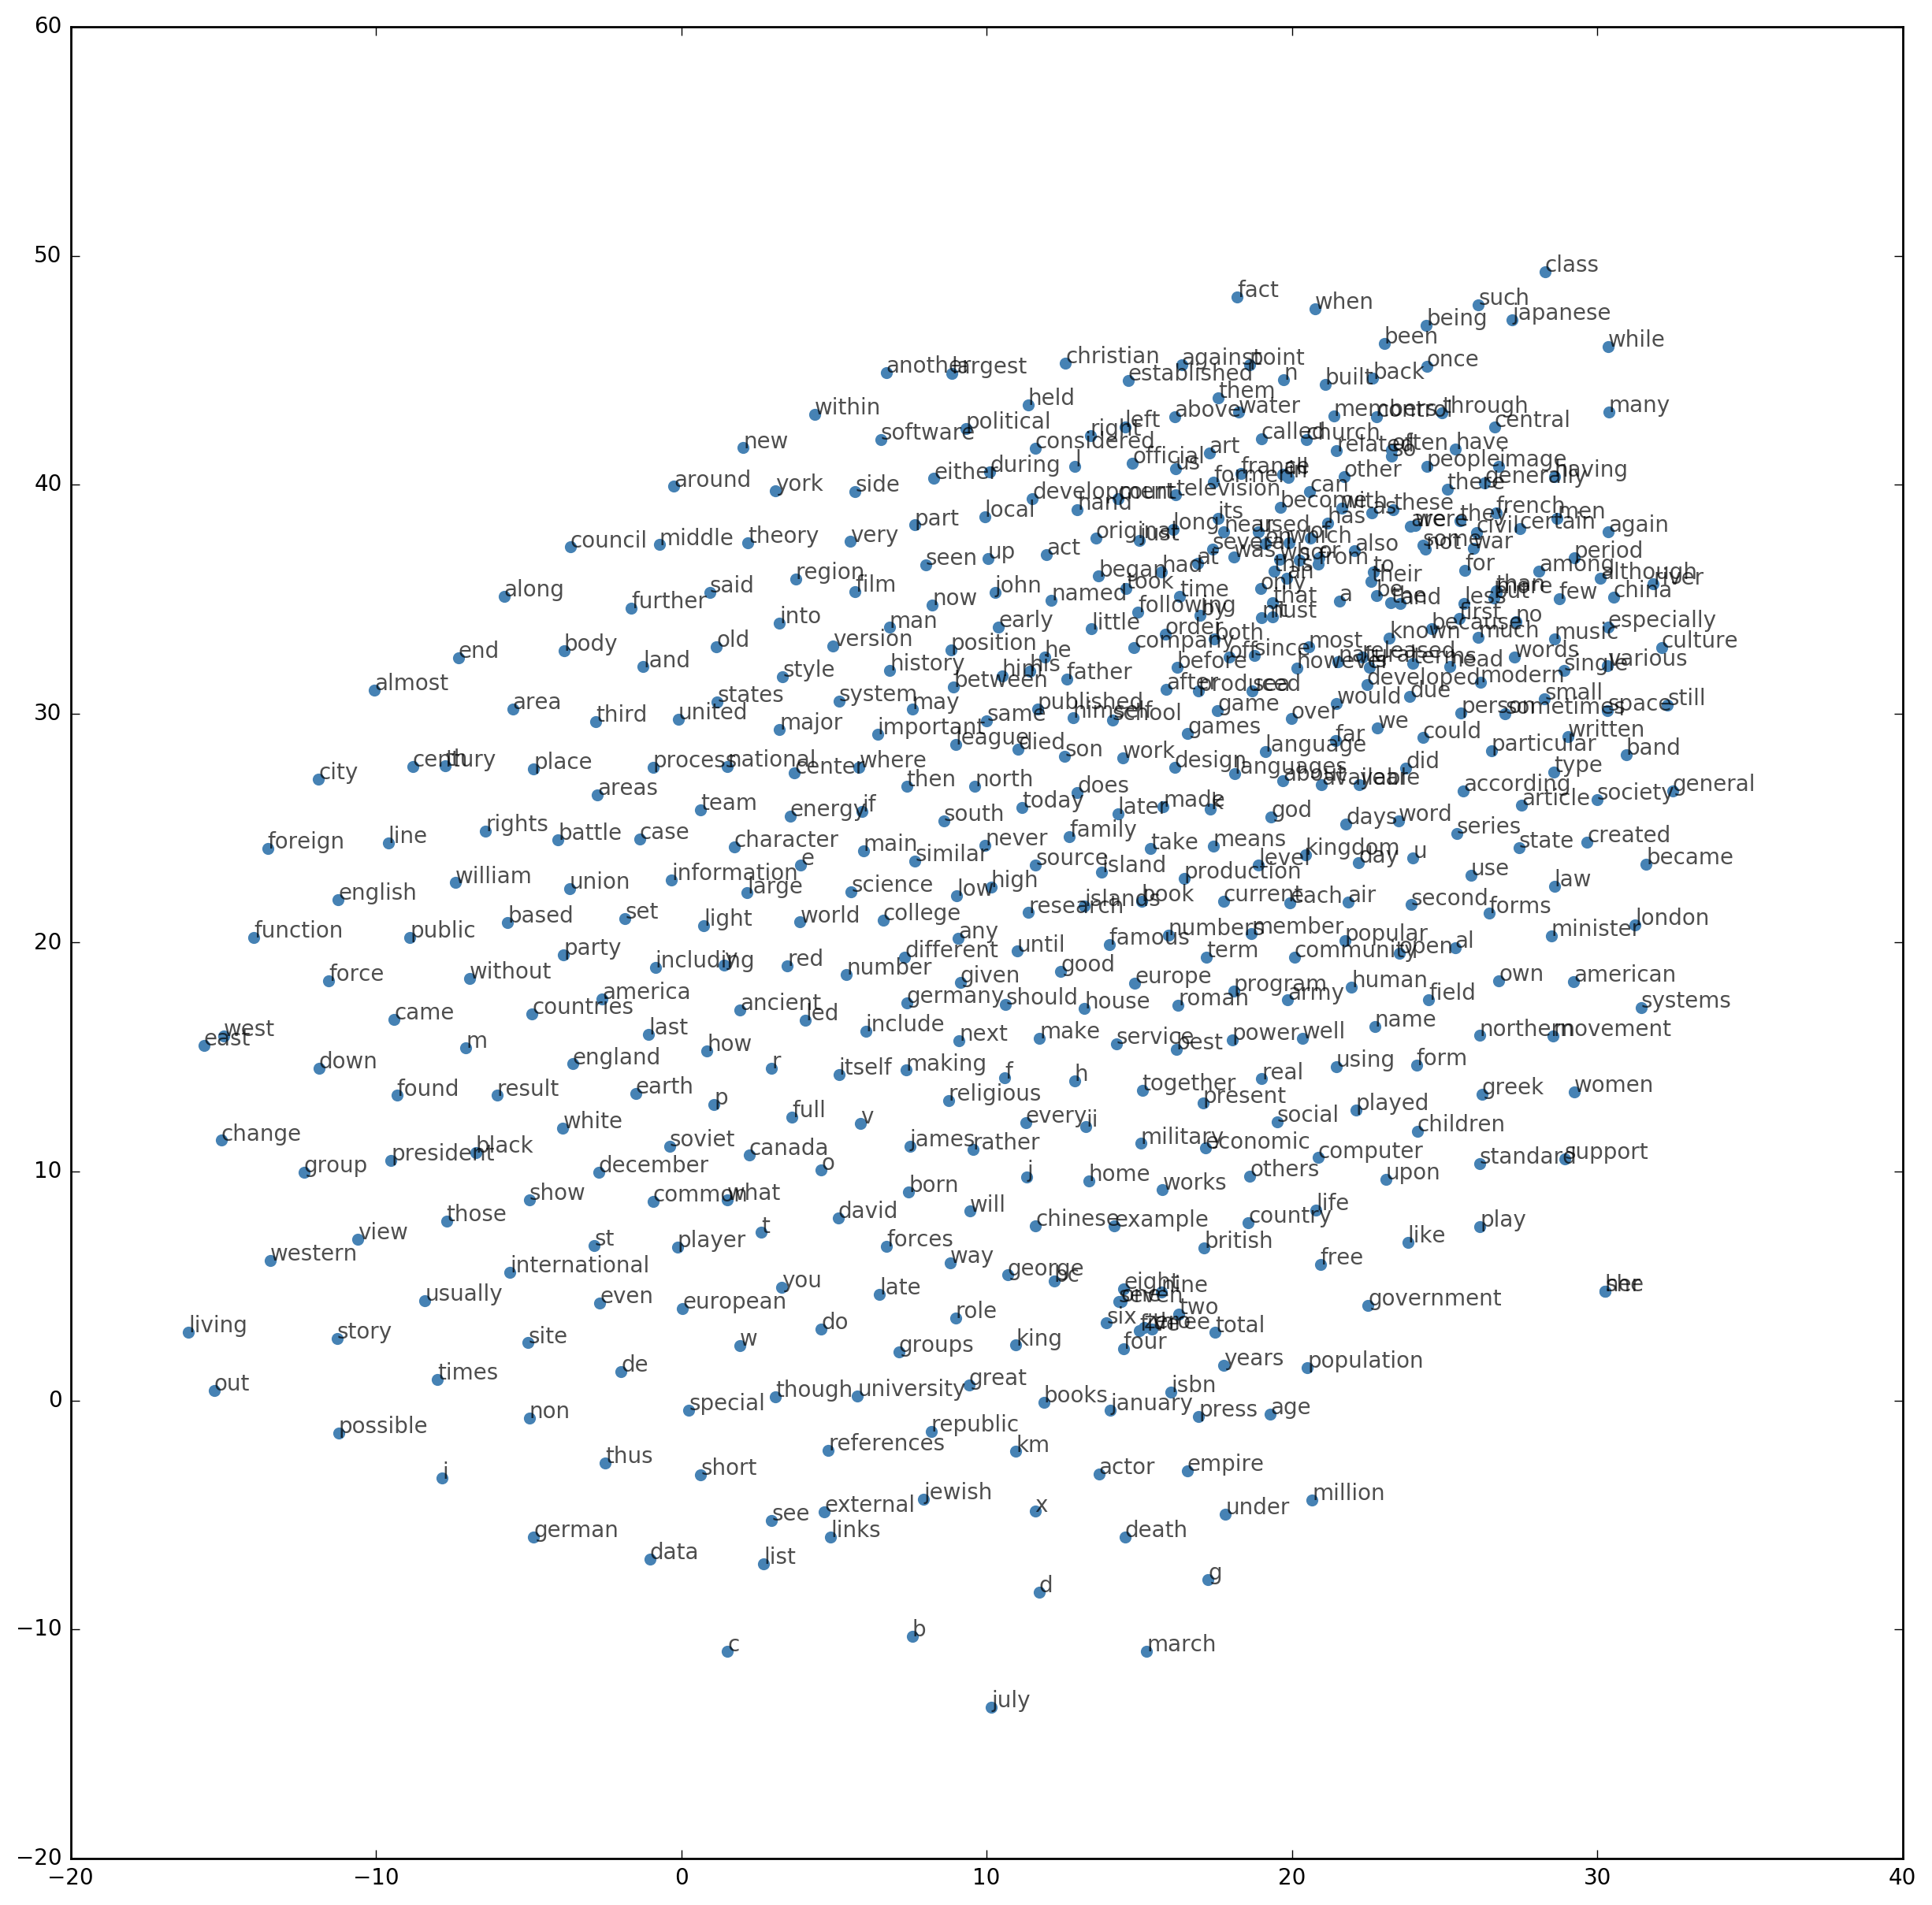

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)